In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from matplotlib import pyplot as plt
from scipy import interpolate
import numpy.ma as ma

## Part 1

In [2]:
def projectPoints(im1, im2, N):
    p1, p2 = getPoints(im1, im2, N)
    H = computeH(p1, p2)
    fig1.suptitle('Choose an arbitrary point from the left image')
    plt.draw()
    arbitraryPoint = np.asarray(fig1.ginput(n=1, timeout=-1)[0])
    axes1[0].scatter(arbitraryPoint[0], arbitraryPoint[1], marker='x',
                     color='green')
    plt.draw()
    arbitraryPoint = np.array([arbitraryPoint[0], arbitraryPoint[1], 1])
    projectedPoint = np.matmul(H, arbitraryPoint)
    projectedPoint = projectedPoint / projectedPoint[-1]
    axes1[1].scatter(projectedPoint[0], projectedPoint[1], marker='o',
                     color='green')
    fig1.suptitle('The green circle on the right image is the corresponding '
                  'point')
    plt.draw()
    plt.savefig("../output/Section 1.2 - Transformation Correctness "
                "Example.png")


In [3]:
def getPoints(im1, im2, N):
    fig1, axes1 = plt.subplots(1, 2)
    axes1[0].imshow(im1)
    axes1[1].imshow(im2)
    axes1[0].set_xticks([])
    axes1[0].set_yticks([])
    axes1[1].set_xticks([])
    axes1[1].set_yticks([])
    fig1.suptitle(f'Click on {N} corresponding points on each image, '
                  f'in alternating order, starting from the left image')

    p1 = []
    p2 = []

    while len(p1) + len(p2) < 2 * N:
        p1.append(np.asarray(fig1.ginput(n=1, timeout=-1)[0]))
        axes1[0].scatter(p1[-1][0], p1[-1][1], marker='x', color='red')
        plt.draw()
        p2.append(np.asarray(fig1.ginput(n=1, timeout=-1)[0]))
        axes1[1].scatter(p2[-1][0], p2[-1][1], marker='x', color='blue')
        plt.draw()
    p1 = np.array(p1)
    p2 = np.array(p2)
    return p1.T, p2.T

In [5]:
im1 = cv2.imread('data/incline_L.png')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('data/incline_R.png')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
#p1, p2 = getPoints(im1, im2, 6)
p1 = np.array([[454.5436828, 511.94919355, 602.95793011, 623.95994624,
                    640.76155914, 612.75887097], [110.43200202, 111.83213642,
                                                  484.26788911, 481.4676203,
                                                  482.8677547, 197.24033535]])
p2 = np.array([[118.05591398, 185.7, 294.24516129, 316.2688172,
                    335.14623656, 294.24516129],
                   [151.48032796, 154.62656452, 536.89430645, 535.32118817,
                    532.17495161, 244.29430645]])

In [6]:
def computeH(p1, p2):
    assert (p1.shape[1] == p2.shape[1])
    assert (p1.shape[0] == 2)

    N = p1.shape[1]
    A = np.zeros((2 * N, 9))

    p1 = np.vstack([p1, np.ones(N)])
    A[range(0, 2 * N, 2), 0:3] = p1.T
    A[range(1, 2 * N, 2), 3:6] = p1.T
    A[range(0, 2 * N, 2), 6:8] = -p1[0:2].T * np.array([p2[0], p2[0]]).T
    A[range(1, 2 * N, 2), 6:8] = -p1[0:2].T * np.array([p2[1], p2[1]]).T
    A[range(0, 2 * N, 2), 8] = -p2[0].T
    A[range(1, 2 * N, 2), 8] = -p2[1].T

    _lambda, V = np.linalg.eig(np.matmul(A.T, A))
    indexOfSmallestLambda = np.abs(_lambda).argmin()
    H2to1 = V[:, indexOfSmallestLambda].reshape(3, 3)

    return H2to1


In [7]:
    H = computeH(p1, p2)

In [8]:
def warpH(im1, H, out_size, interpolation_type='linear'):
    # Split im1 into channels
    red_channel_im1 = im1[:, :, 0]
    green_channel_im1 = im1[:, :, 1]
    blue_channel_im1 = im1[:, :, 2]

    # Create channels of output image
    warp_im1_red_channel = np.zeros(out_size[:2])
    warp_im1_green_channel = np.zeros(out_size[:2])
    warp_im1_blue_channel = np.zeros(out_size[:2])

    # Create mappings for interpolation
    upper_left_corner = H @ np.array([0, 0, 1]).T
    upper_left_corner = upper_left_corner / upper_left_corner[2]

    bottom_left_corner = H @ np.array([0, out_size[0], 1]).T
    bottom_left_corner = bottom_left_corner / bottom_left_corner[2]

    upper_right_corner = H @ np.array([out_size[1], 0, 1]).T
    upper_right_corner = upper_right_corner / upper_right_corner[2]

    x_grid = np.linspace(upper_left_corner[0], upper_right_corner[0],        im1.shape[1])
    y_grid = np.linspace(upper_left_corner[1], bottom_left_corner[1],        im1.shape[0])

    # Interpolate by channel
    f_red = interpolate.interp2d(x_grid, y_grid, red_channel_im1,
                                 kind=interpolation_type,
                                 fill_value=0)

    f_green = interpolate.interp2d(x_grid, y_grid, green_channel_im1,
                                   kind=interpolation_type,
                                   fill_value=0)

    f_blue = interpolate.interp2d(x_grid, y_grid, blue_channel_im1,
                                  kind=interpolation_type,
                                  fill_value=0)

    for y in range(out_size[0]):
        for x in range(out_size[1]):
            new_coords = H @ np.array([x, y, 1]).T
            new_coords = new_coords / new_coords[2]
            red_value = f_red(new_coords[0], new_coords[1])
            green_value = f_green(new_coords[0], new_coords[1])
            blue_value = f_blue(new_coords[0], new_coords[1])
            warp_im1_red_channel[y, x] = red_value
            warp_im1_green_channel[y, x] = green_value
            warp_im1_blue_channel[y, x] = blue_value

    warp_im1 = np.zeros(out_size)
    warp_im1[:, :, 0] = warp_im1_red_channel
    warp_im1[:, :, 1] = warp_im1_green_channel
    warp_im1[:, :, 2] = warp_im1_blue_channel
    warp_im1 = warp_im1.astype(np.uint8)
    return warp_im1


In [9]:
#testWarped1 = warpH(im1, np.linalg.inv(H), im2.shape, interpolation_type='linear')
#testWarped2 = warpH(im1, np.linalg.inv(H), im2.shape, interpolation_type='cubic')

KeyboardInterrupt: 

In [10]:
def imageStitching(img1, warp_img2):
    panoImg = np.zeros(img1.shape, dtype='uint8')
    img1_mask = np.where(img1 != [0, 0, 0])
    print(img1_mask)
    panoImg = img1
    print(panoImg.shape)
    panoImg[img1_mask] = warp_img2[img1_mask]
    return panoImg

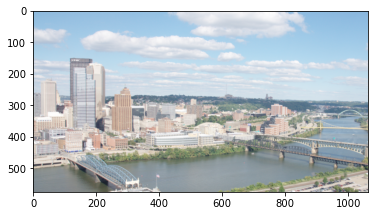

In [49]:
plt.imshow(im2)

(576, 1064, 3)
(576, 1064, 3)
(array([  0,   0,   0, ..., 575, 575, 575]), array([0, 0, 0, ..., 9, 9, 9]), array([0, 1, 2, ..., 0, 1, 2]))
(576, 1064, 3)


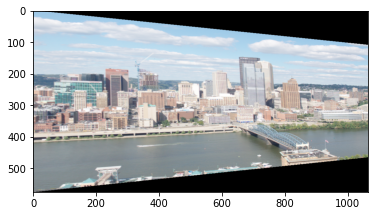

In [35]:
print(im2.shape)
print(testWarped1.shape)
plt.imshow(imageStitching(im2, testWarped1))

In [47]:
def getPoints_SIFT(im1, im2):

  # Initiate the SIFT detector
  sift = cv2.xfeatures2d.SIFT_create()

  # Find the keypoints and descriptors
  kp_im1, desc_im1 = sift.detectAndCompute(im1, None)
  kp_im2, desc_im2 = sift.detectAndCompute(im2, None)

  # Match keypoints using L2 norm - documentation said that it is good for SIFT
  # Use crossCheck=true which ensures that the matcher returns only those matches 
  # with value (i,j) such that i-th descriptor in set A has j-th descriptor in 
  # set B as the best match and vice-versa.
  brute_force = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  # Get best matches of the two images
  matches = brute_force.match(desc_im1, desc_im2)
  
  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  p1 = np.float32([ kp_im1[m.queryIdx].pt for m in matches ]).T
  p2 = np.float32([ kp_im2[m.trainIdx].pt for m in matches ]).T

  print(p1.shape)

  return p1, p2

In [48]:
p1_SIFT, p2_SIFT = getPoints_SIFT(im1, im2)
H_SIFT = computeH(p1_SIFT, p2_SIFT)
warped_ = warpH(im1, H_SIFT, out_size, interpolation_type='linear')

(2, 2157)


(array([[652.6592  , 638.78253 , 554.88525 , ...,  56.038887, 290.79117 ,
         198.5909  ],
        [216.88753 , 300.32596 , 159.42767 , ..., 289.3263  , 372.79593 ,
         268.26282 ]], dtype=float32),
 array([[334.7434 , 322.73782, 232.6444 , ..., 496.19705, 282.94482,
         194.45833],
        [267.38242, 350.3909 , 207.17776, ..., 323.19794, 559.33417,
         379.17233]], dtype=float32))